In [1]:
from dataset import get_mel_spectrogram

file_path = r"C:\Users\park3\park\Repository\MIRProject-VocalTagging\data\likeme_a.wav"
state_path = r"C:\Users\park3\park\Repository\MIRProject-VocalTagging\results\model_15.pt"

mel_spec = get_mel_spectrogram(file_path, SR=22050)

In [7]:
import torch

THRESHOLDS = torch.tensor([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
                           0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 
                           0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 
                           0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 
                           0.5, 0.5])

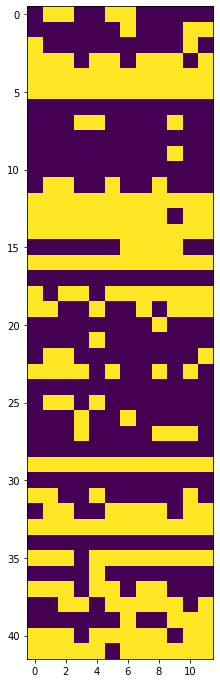

In [15]:
import torch.nn as nn
import matplotlib.pyplot as plt

from model import base_model

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

mel_spec = mel_spec.to(DEVICE)
num_segs = mel_spec.size(-1)//107

outputs = torch.zeros(num_segs, 42).to(DEVICE)
model = base_model().to(DEVICE)
model.load_state_dict(torch.load(state_path, map_location=DEVICE))

for i in range(num_segs):
    output = model(mel_spec[:,:,i*107:(i+1)*107].unsqueeze(0))
    outputs[i, :] = output[0]

prediction = (outputs > THRESHOLDS).to(int).T
plt.figure(figsize=(10,1*outputs.size(0)))
plt.imshow(prediction)
plt.show()